# Project 4: Football matches as mobility networks
During a football match, players move on the field to attack and defend. This generates a series of movements that can be analyzed to understand the players behavior.<br><br>
The student should use the `Wyscout open dataset`, describing the “events” in all matches of seven competitions (e.g., passes, shots, tackles etc.), to analyze pass chains and the mobility of football players. A player’s movement is defined by consecutive events made by that player in the match.<br><br>
- Investigate the distances traveled by players during their matches and their distributions. Discuss about the similarity of these distributions with those about mobility trajectories seen during the course.<br><br>
- <b>Relate the pass chains made by teams with the probability of making a shot, a goal, and to win a match. Are long chains more likely to lead to a shot/goal? Are short pass chains more successful?</b><br><br>
- Quantify the predictability of pass chains based on some division of the football field (tessellation). To what extent can we predict the next tile (field zone) where the ball will be? Use a next-location predictor to quantify the accuracy to predict the next zone the ball will be.

In [1]:
import json
import pandas as pd
from numpy import NaN
from utils import *
import seaborn as sns
import matplotlib.pyplot as plt
from utils import *

import warnings
warnings.filterwarnings('ignore')

### Data load

In [2]:
# loading the events data
events={}
nations = ['Italy','England','Germany','France','Spain','European_Championship','World_Cup']
for nation in nations:
    with open('./data/events/events_%s.json' %nation) as json_data:
        events[nation] = json.load(json_data)

### JSON to DataFrame

In [3]:
events_df = {
    'Italy': pd.DataFrame(events['Italy']),
    'England': pd.DataFrame(events['England']),
    'Germany': pd.DataFrame(events['Germany']),
    'France': pd.DataFrame(events['France']),
    'Spain': pd.DataFrame(events['Spain']),
    'European_Championship': pd.DataFrame(events['European_Championship']),
    'World_Cup': pd.DataFrame(events['World_Cup'])
}

In [4]:
events = 0

### Preprocessing

In [10]:
total_passes_counts = pd.DataFrame()
total_goals_passes_counts = pd.DataFrame()
total_comparison = pd.DataFrame()

In [5]:
for events in events_df.values():
    events['tags'] = events['tags'].apply(extract_tags)

In [6]:
def pass_chain_analysis(competition_area, competition_name):
    competition_events = events_df[competition_area]

    passes_before_shot = get_passes_before_shot(competition_events)
    competition_passes_counts = count_passes_before_shot(passes_before_shot)
    competition_passes_counts['duel'] = True

    goals = competition_events[competition_events['tags'].apply(lambda x: 101 in x)]
    goals = goals[goals['subEventName'] == 'Shot']

    passes_before_goal = {}
    for index, row in goals.iterrows():
        match_id = row['matchId']
        event_sec = row['eventSec']
        
        passes_before_goal[match_id, event_sec] = passes_before_shot[match_id, event_sec]

    competition_goals_passes_counts = count_passes_before_shot(passes_before_goal)
    competition_goals_passes_counts['duel'] = True

    # this part is the same as the previous computation but removing the duels (specifically, all the events with eventId equal to 1
    # and subEventId equal to 11, 12 or 13)

    competition_events = competition_events[(competition_events['eventId'] != 1) & (~competition_events['subEventId'].isin([11, 12]))].reset_index(drop=True)

    passes_before_shot_no_duel = get_passes_before_shot(competition_events)
    competition_passes_counts_no_duels = count_passes_before_shot(passes_before_shot_no_duel)

    competition_passes_counts_no_duels['duel'] = False

    goals = competition_events[competition_events['tags'].apply(lambda x: 101 in x)]
    goals = goals[goals['subEventName'] == 'Shot']

    passes_before_goal_no_duel = {}
    for index, row in goals.iterrows():
        match_id = row['matchId']
        event_sec = row['eventSec']
        
        passes_before_goal_no_duel[match_id, event_sec] = passes_before_shot_no_duel[match_id, event_sec]

    competition_goals_passes_counts_no_duels = count_passes_before_shot(passes_before_goal_no_duel)
    competition_goals_passes_counts_no_duels['duel'] = False
    
    competition_passes_counts = pd.concat([competition_passes_counts, competition_passes_counts_no_duels])
    competition_goals_passes_counts = pd.concat([competition_goals_passes_counts, competition_goals_passes_counts_no_duels])

    competition_passes_counts_no_duels.rename(columns={'duel': 'Goal'}, inplace=True)
    competition_goals_passes_counts_no_duels.rename(columns={'duel': 'Goal'}, inplace=True)
    competition_goals_passes_counts_no_duels['Goal'] = True

    comparison_goals_passes_counts = pd.concat([competition_passes_counts_no_duels, competition_goals_passes_counts_no_duels])

    # plots
    plot_histogram_pass_chain(competition_passes_counts, 'Passes', 'count', 'Number of Passes Before Shot', 'Count', 'Number of Passes Before Shot in the %s' %competition_name)
    plot_histogram_pass_chain(competition_goals_passes_counts, 'Passes', 'count', 'Number of Passes Before a goal', 'Count', 'Number of Passes Before a goal in the %s' %competition_name)
    plot_histogram_comparison_pass_chain(comparison_goals_passes_counts, 'Passes', 'count', 'Number of Passes Before Shot', 'Count', 'Comparison between shots and goals in the %s (with no duels)' %competition_name)

    #update the total dataframes
    return competition_passes_counts, competition_goals_passes_counts, comparison_goals_passes_counts

In [25]:
def total_analysis(total_passes_counts, total_goals_passes_counts, total_comparison):
    total_passes_counts = total_passes_counts.groupby(['Passes', 'duel'])['count'].sum().to_frame().reset_index()
    total_goals_passes_counts = total_goals_passes_counts.groupby(['Passes', 'duel'])['count'].sum().to_frame().reset_index()
    total_comparison = total_comparison.groupby(['Passes', 'Goal'])['count'].sum().to_frame().reset_index()
    
    plot_histogram_pass_chain(total_passes_counts, 'Passes', 'count', 'Number of Passes Before Shot', 'Count', 'Number of Passes Before Shot in all the competitions')
    plot_histogram_pass_chain(total_goals_passes_counts, 'Passes', 'count', 'Number of Passes Before a goal', 'Count', 'Number of Passes Before a goal in all the competitions')
    plot_histogram_comparison_pass_chain(total_comparison, 'Passes', 'count', 'Number of Passes Before Shot', 'Count', 'Comparison between shots and goals in all the competitions')

### Italian pass chains analysis

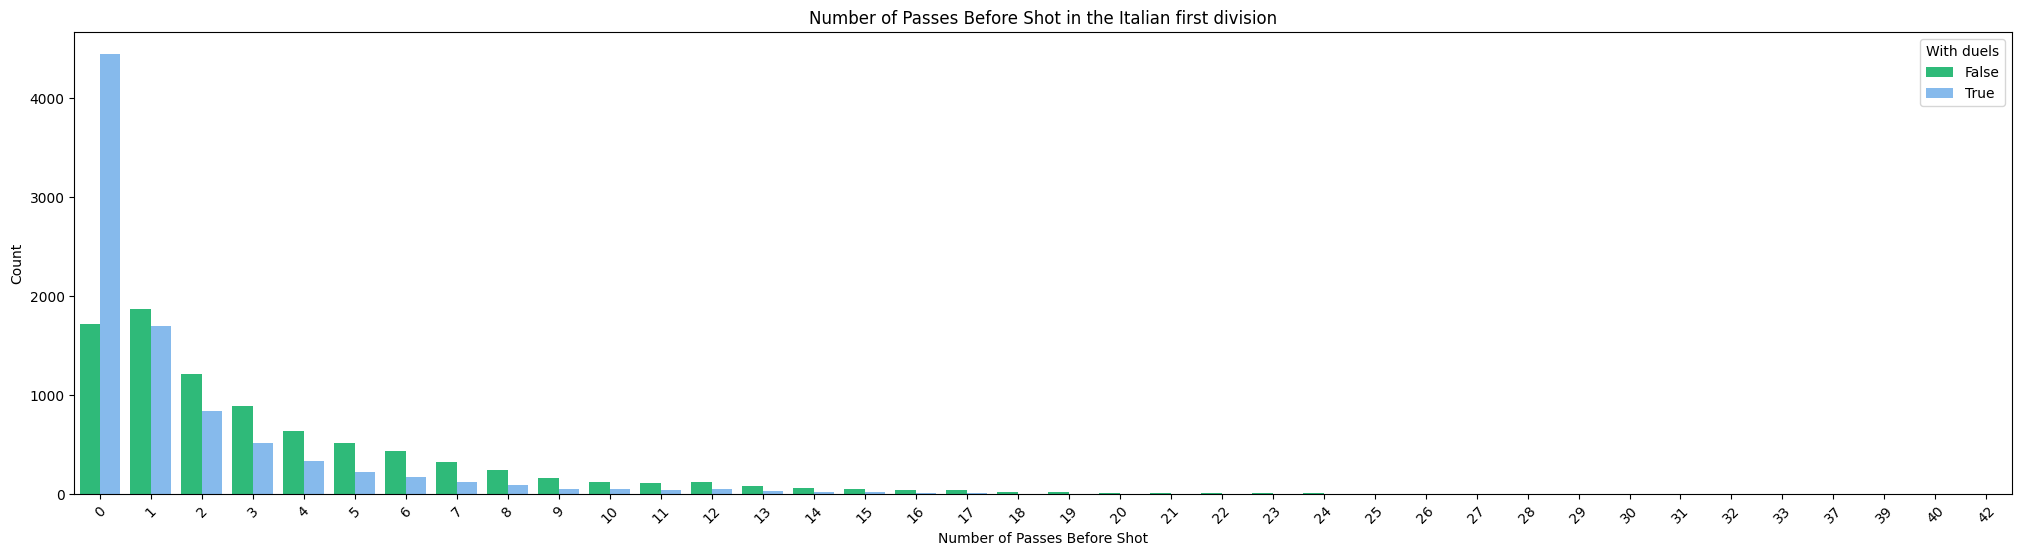

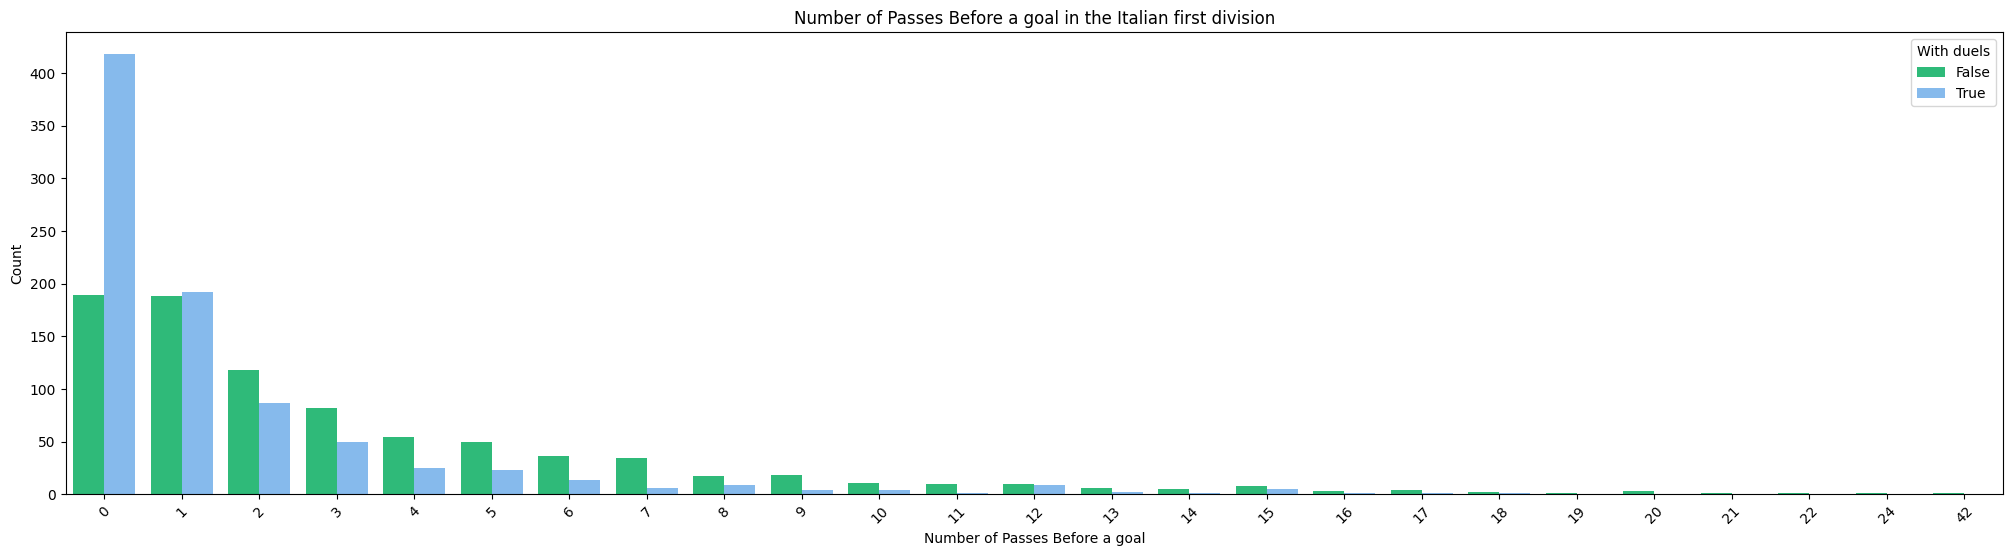

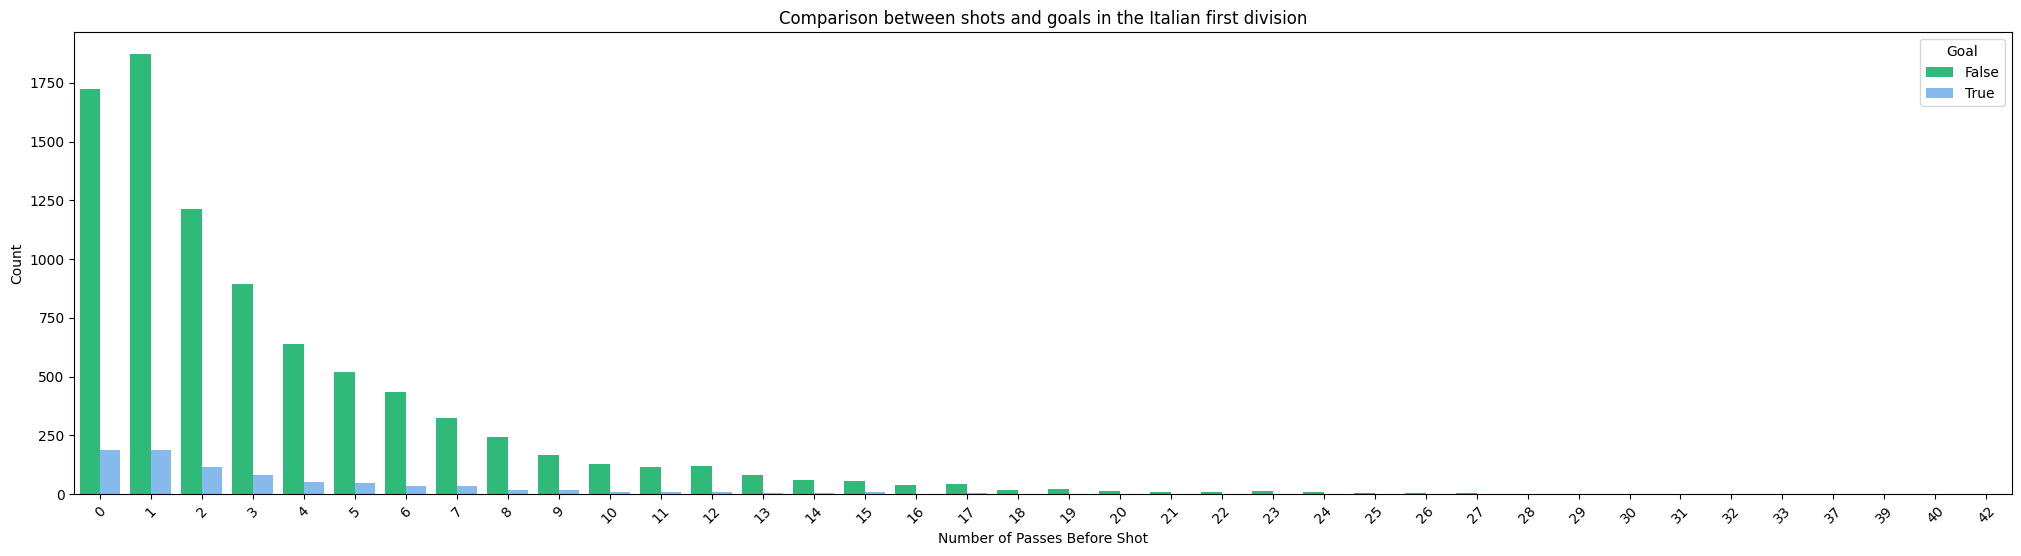

In [11]:
df1, df2, df3 = pass_chain_analysis('Italy', 'Italian first division')
total_passes_counts = pd.concat([total_passes_counts, df1])
total_goals_passes_counts = pd.concat([total_goals_passes_counts, df2])
total_comparison = pd.concat([total_comparison, df3])

### English pass chains analysis

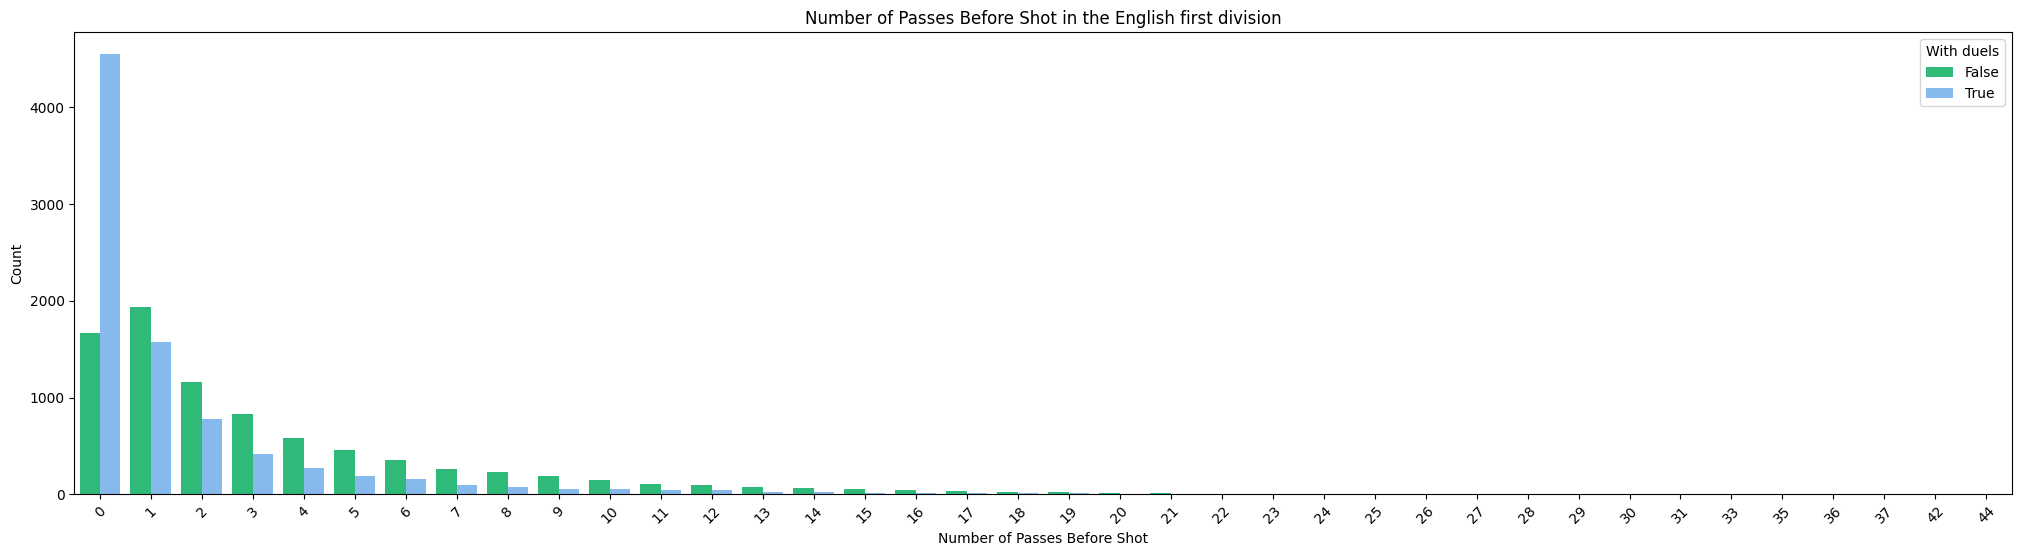

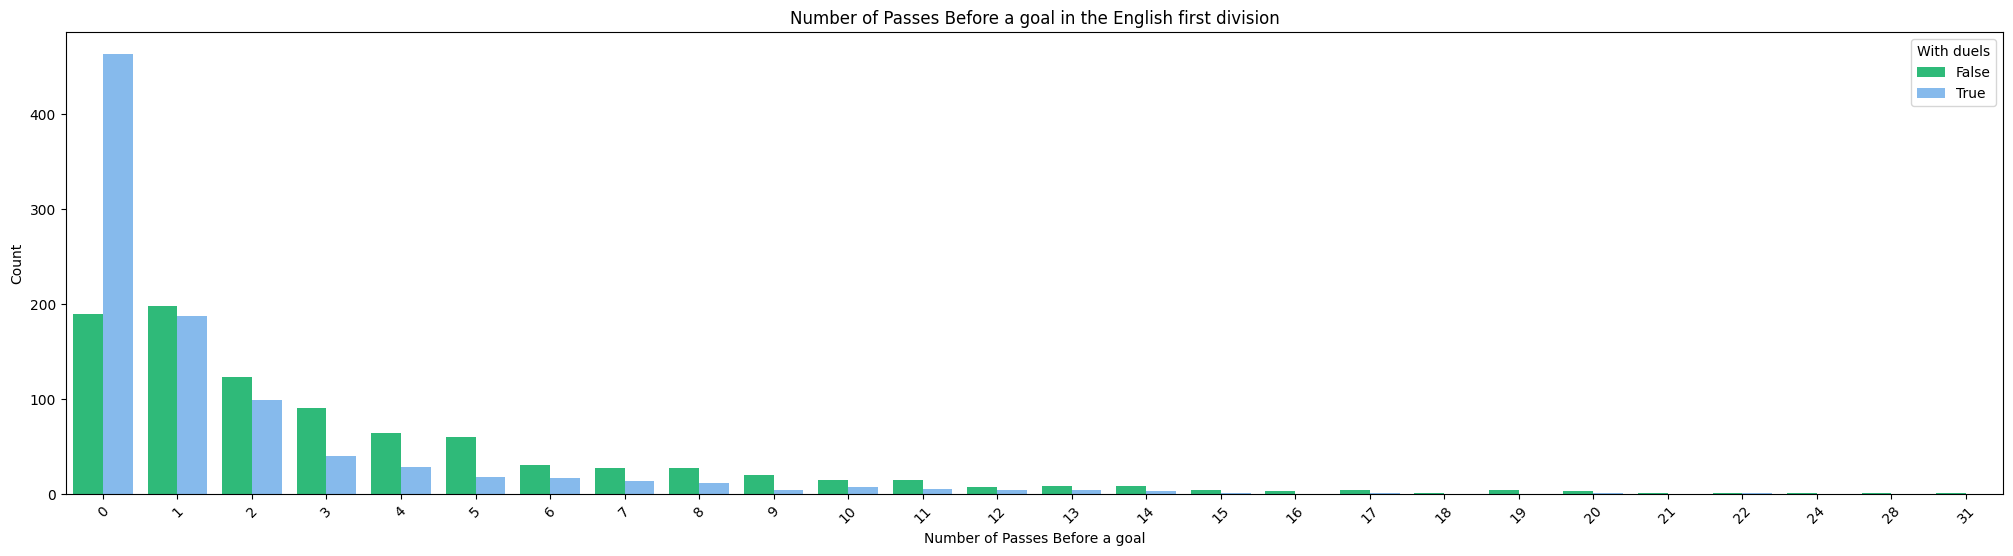

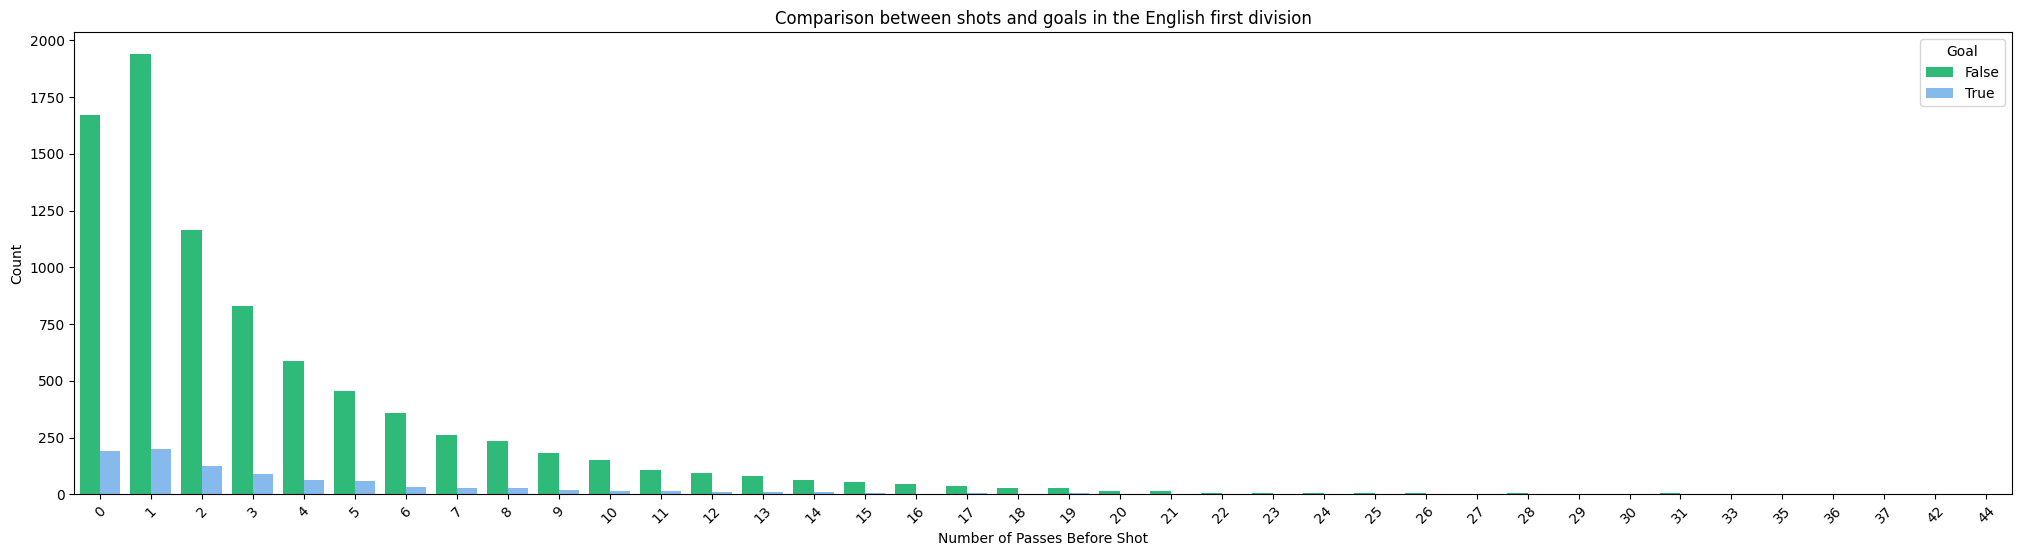

In [12]:
df1, df2, df3 = pass_chain_analysis('England', 'English first division')
total_passes_counts = pd.concat([total_passes_counts, df1])
total_goals_passes_counts = pd.concat([total_goals_passes_counts, df2])
total_comparison = pd.concat([total_comparison, df3])

### Spanish pass chain analysis

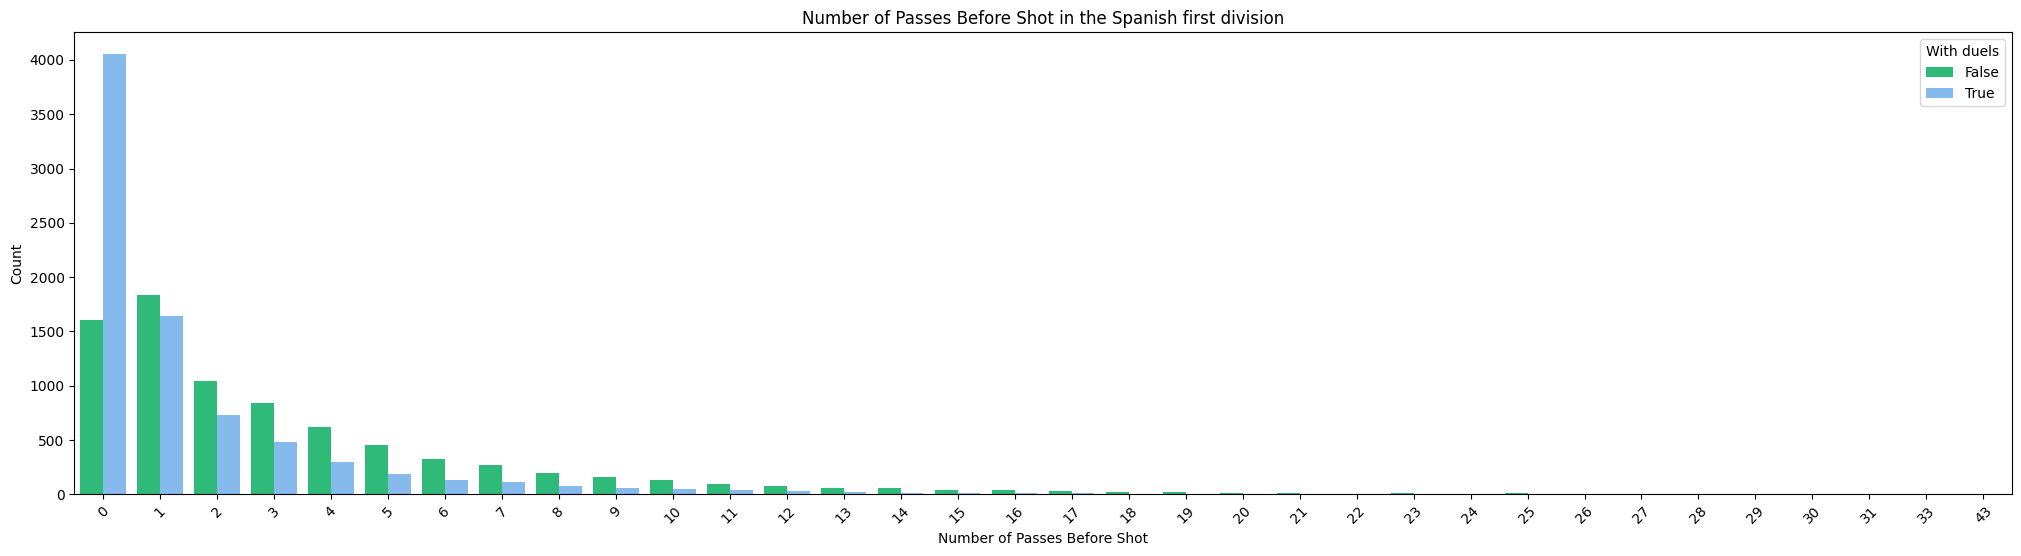

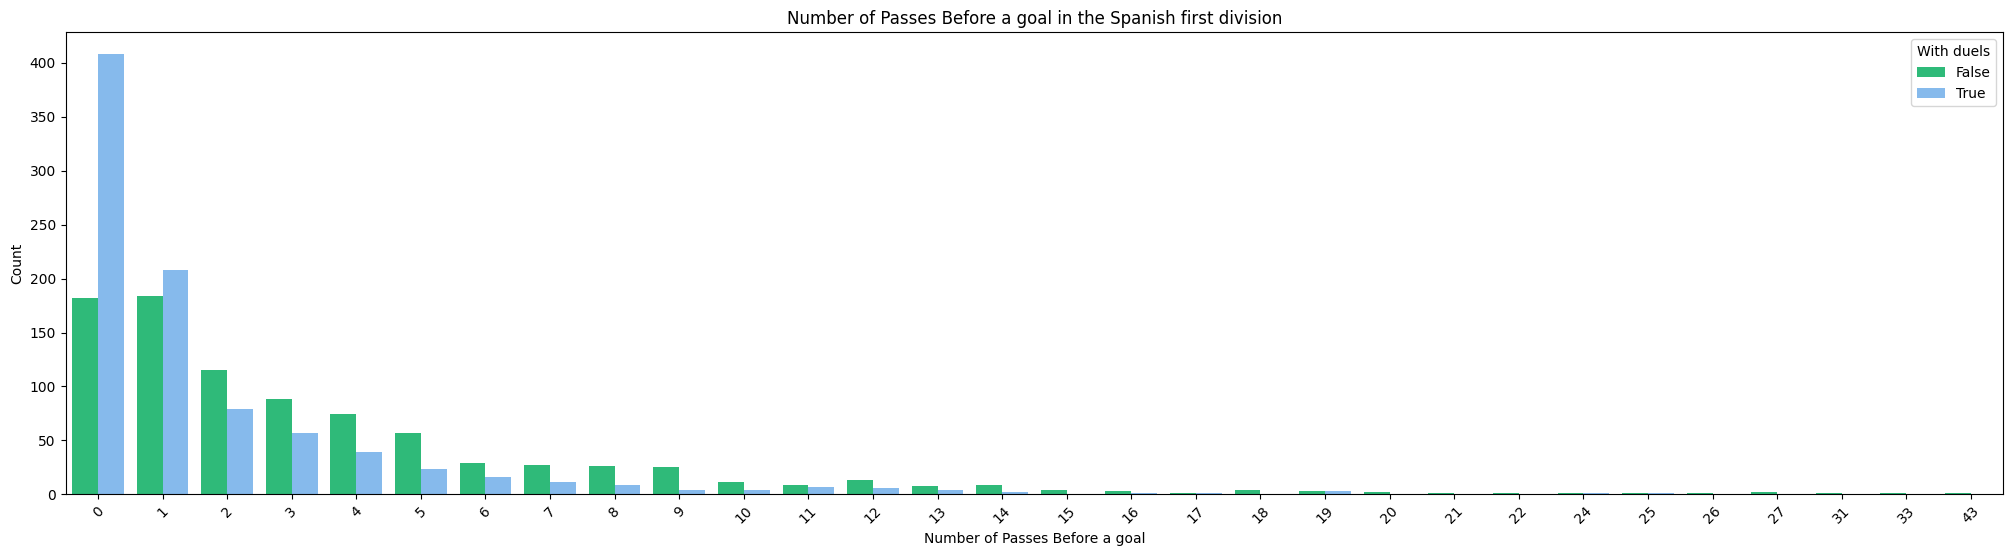

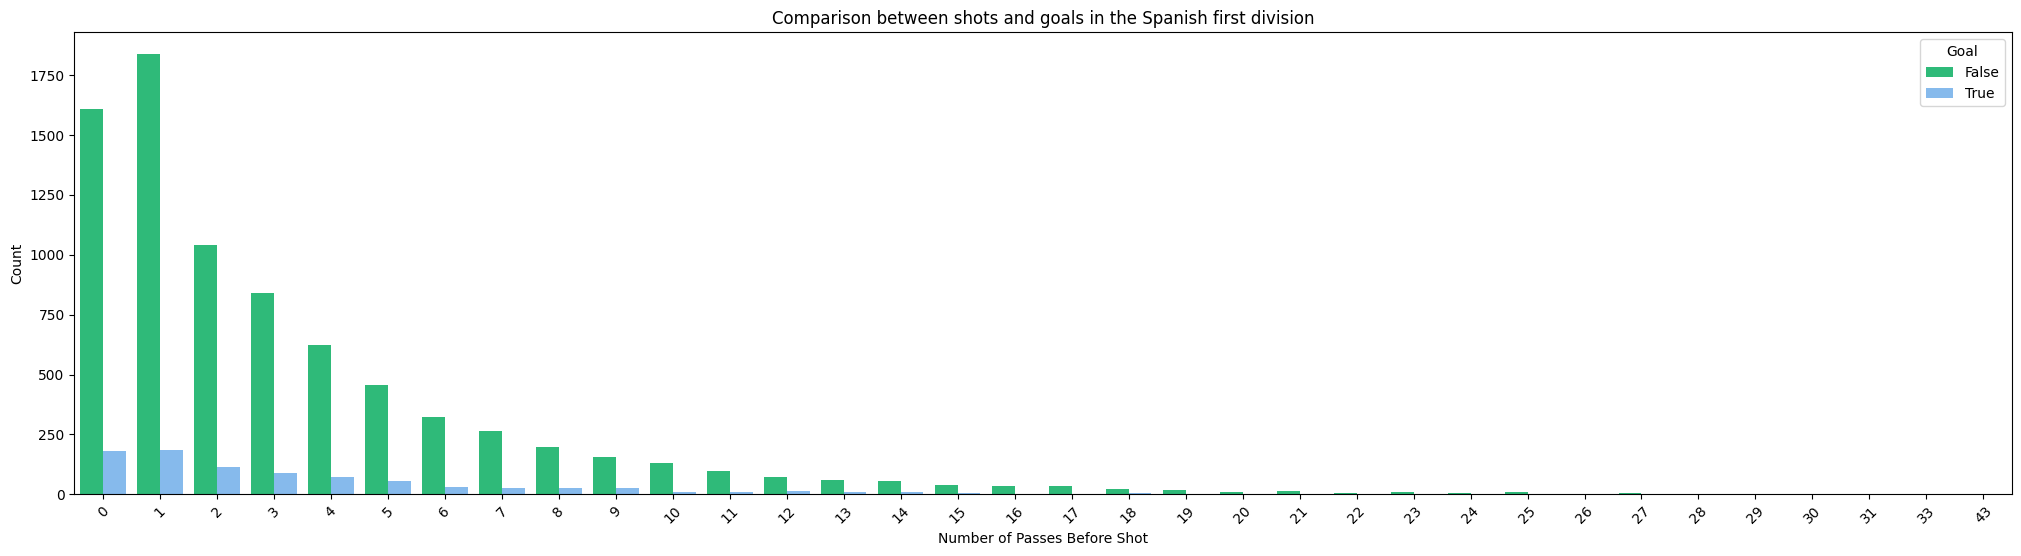

In [13]:
df1, df2, df3 = pass_chain_analysis('Spain', 'Spanish first division')
total_passes_counts = pd.concat([total_passes_counts, df1])
total_goals_passes_counts = pd.concat([total_goals_passes_counts, df2])
total_comparison = pd.concat([total_comparison, df3])

### German pass chain analysis

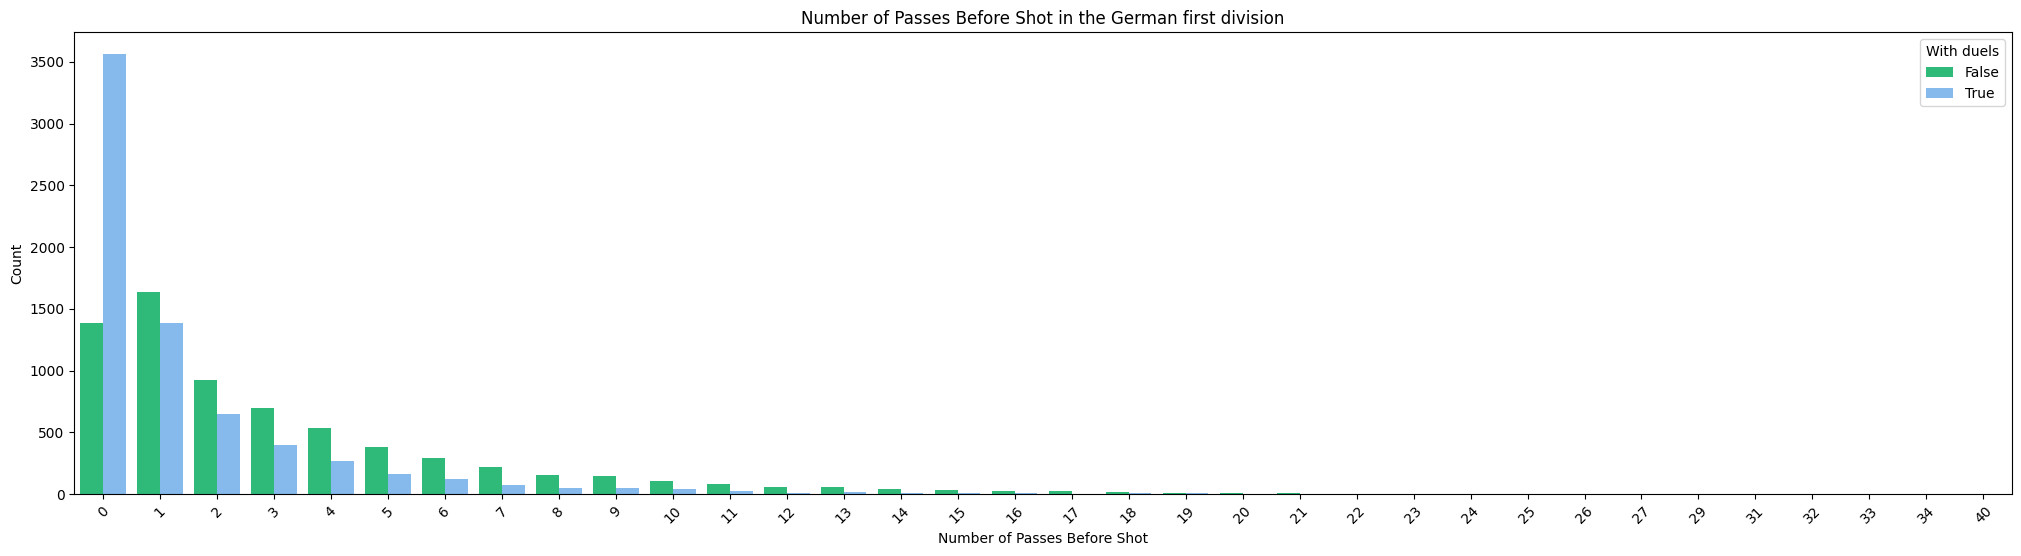

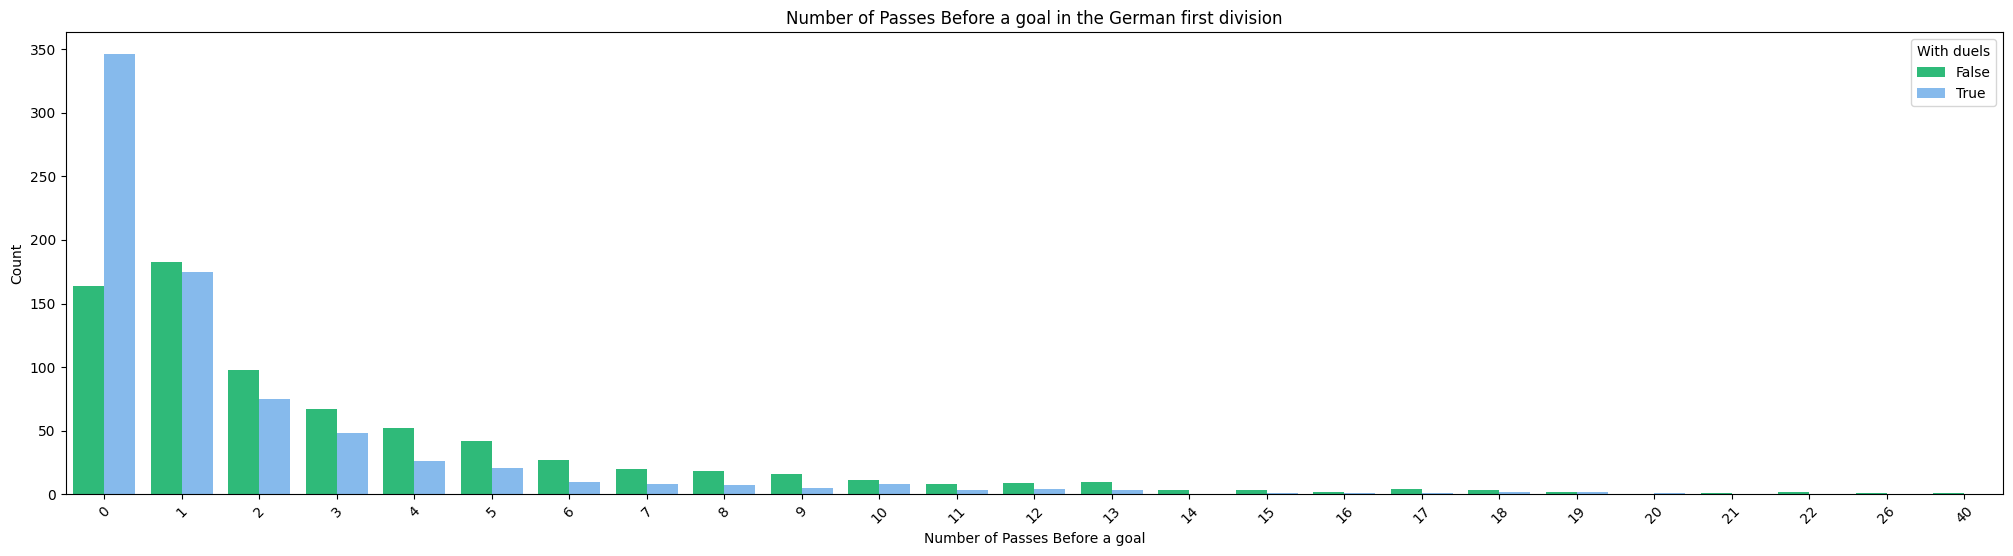

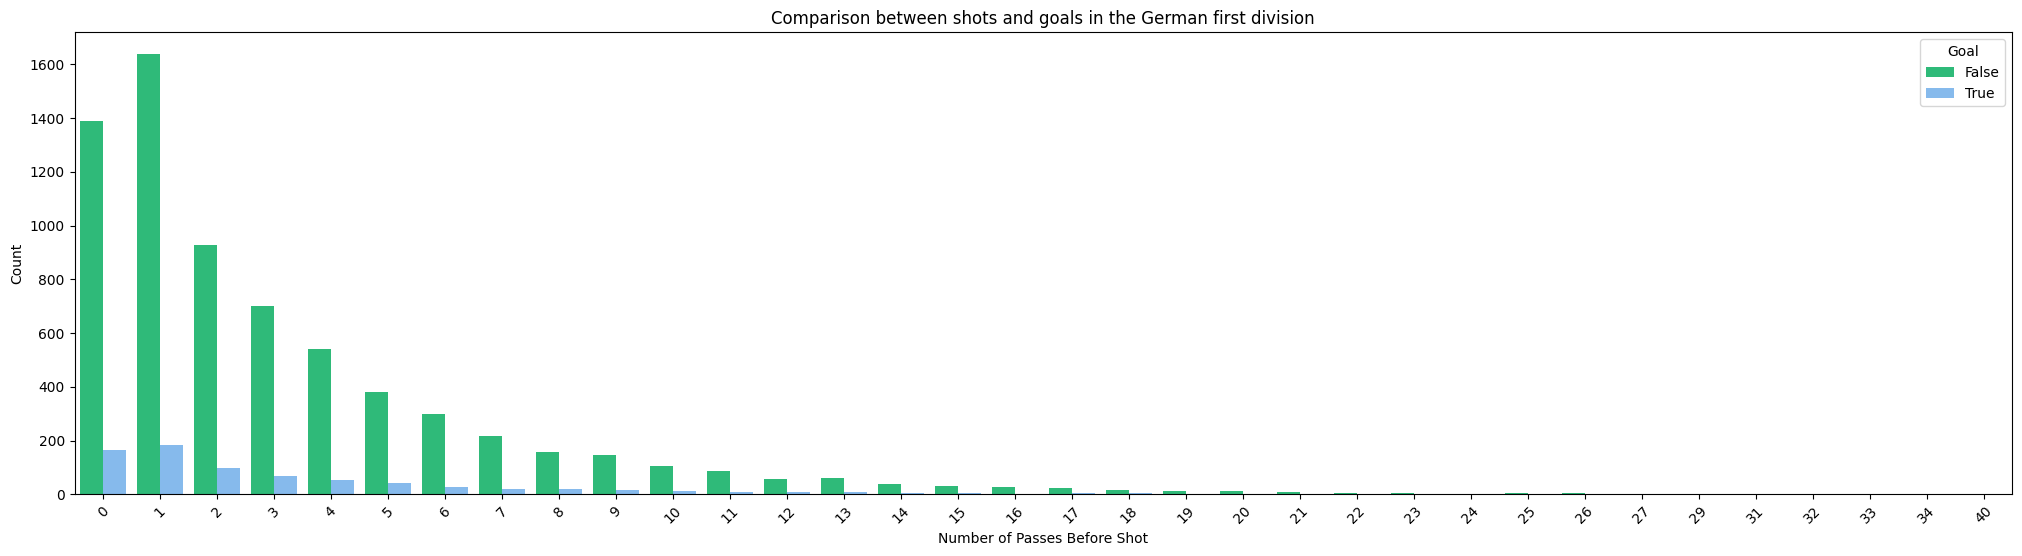

In [14]:
df1, df2, df3 = pass_chain_analysis('Germany', 'German first division')
total_passes_counts = pd.concat([total_passes_counts, df1])
total_goals_passes_counts = pd.concat([total_goals_passes_counts, df2])
total_comparison = pd.concat([total_comparison, df3])

### French pass chain analysis

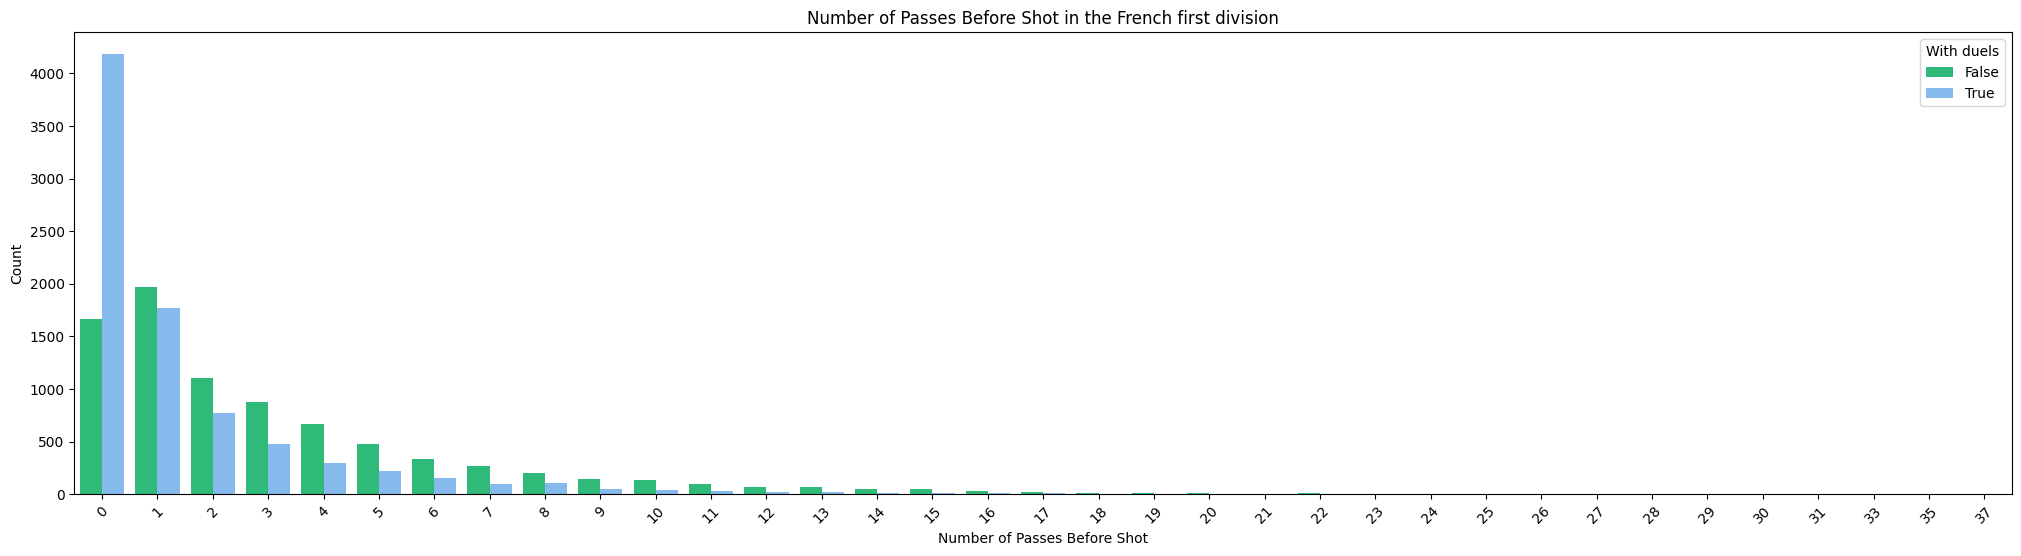

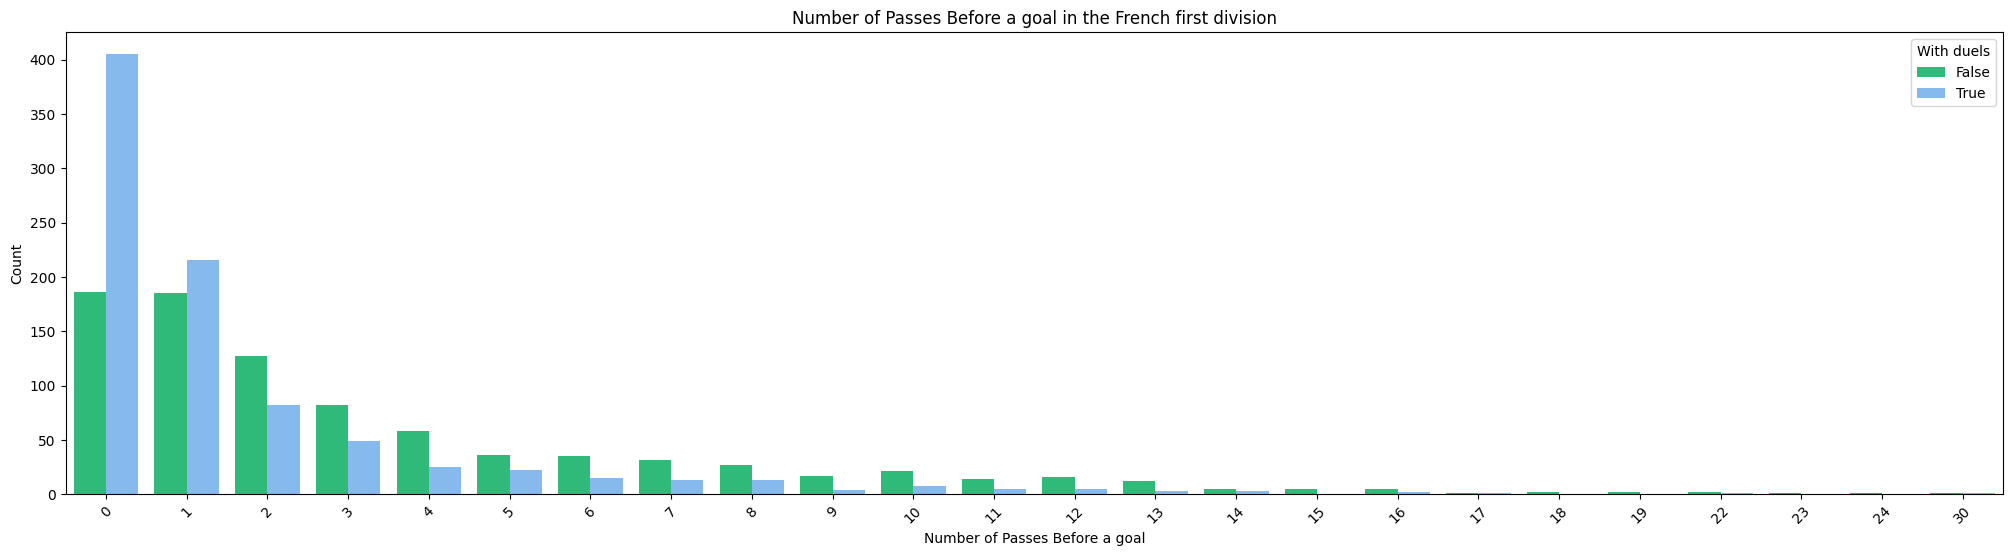

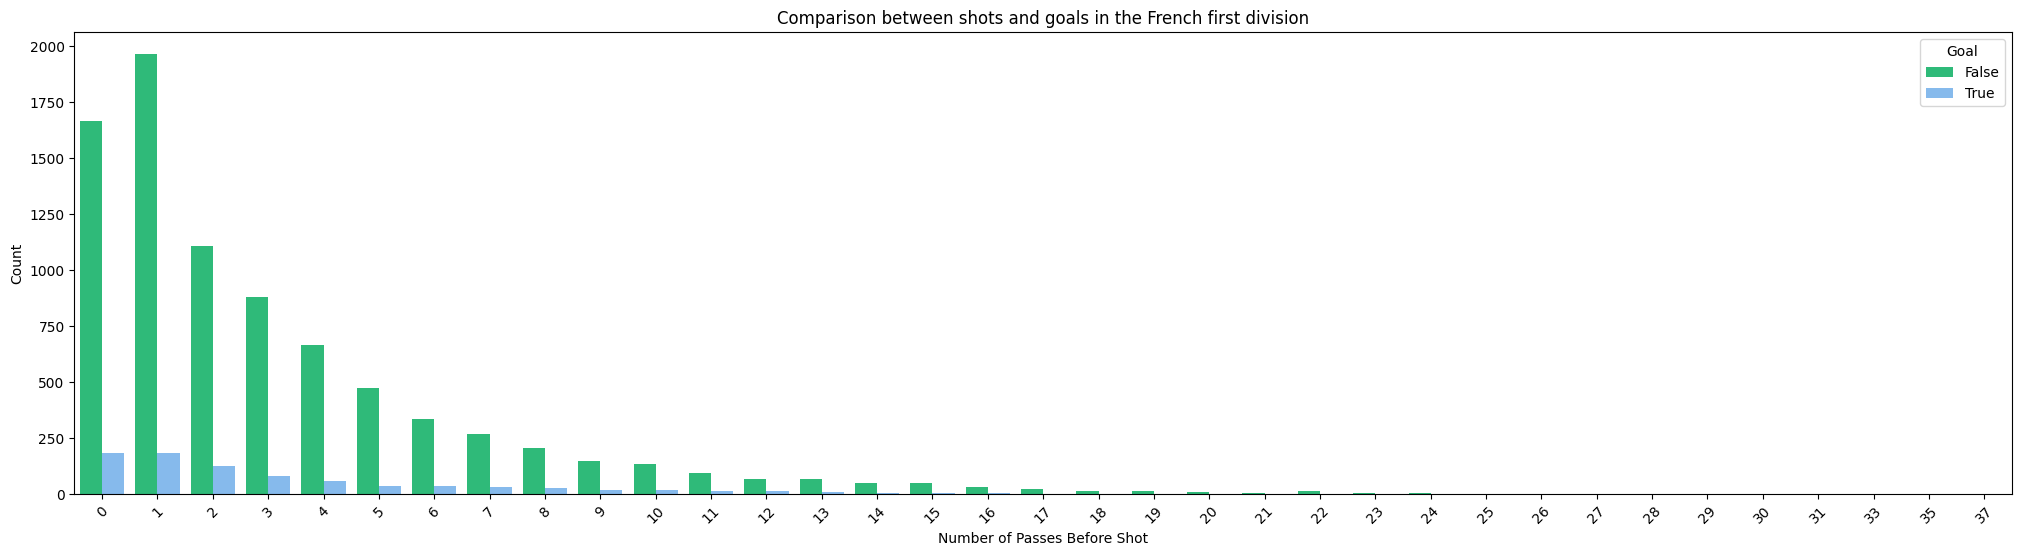

In [15]:
df1, df2, df3 = pass_chain_analysis('France', 'French first division')
total_passes_counts = pd.concat([total_passes_counts, df1])
total_goals_passes_counts = pd.concat([total_goals_passes_counts, df2])
total_comparison = pd.concat([total_comparison, df3])

### European Championship pass chain analysis

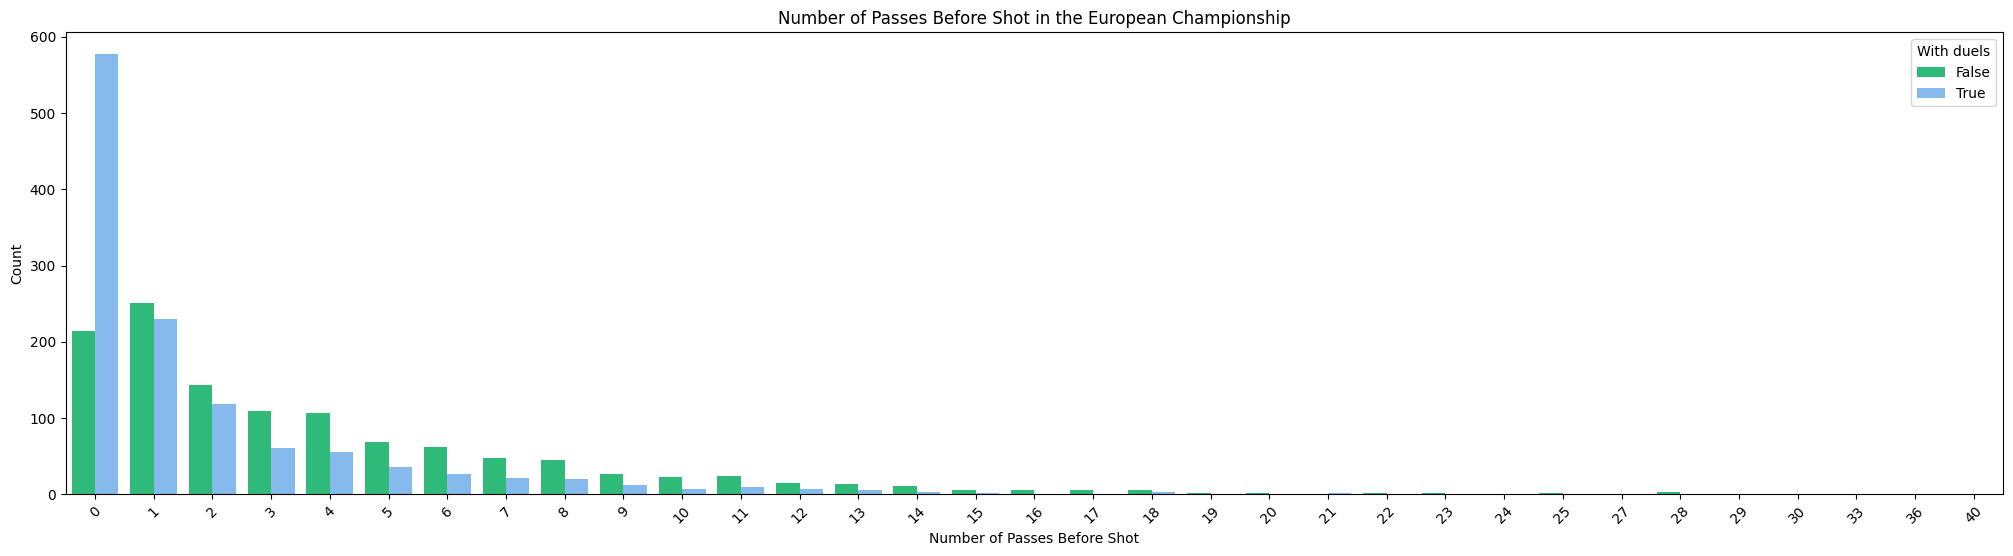

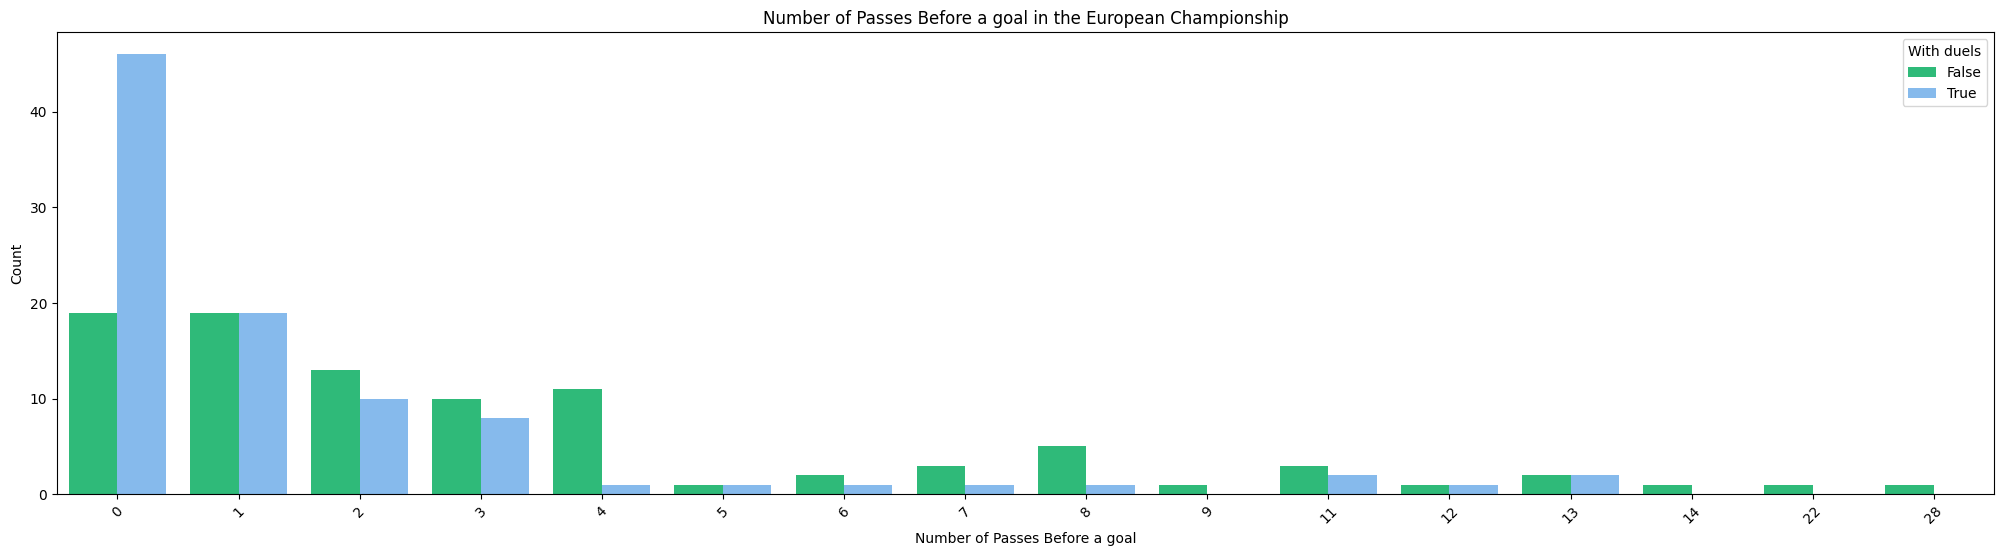

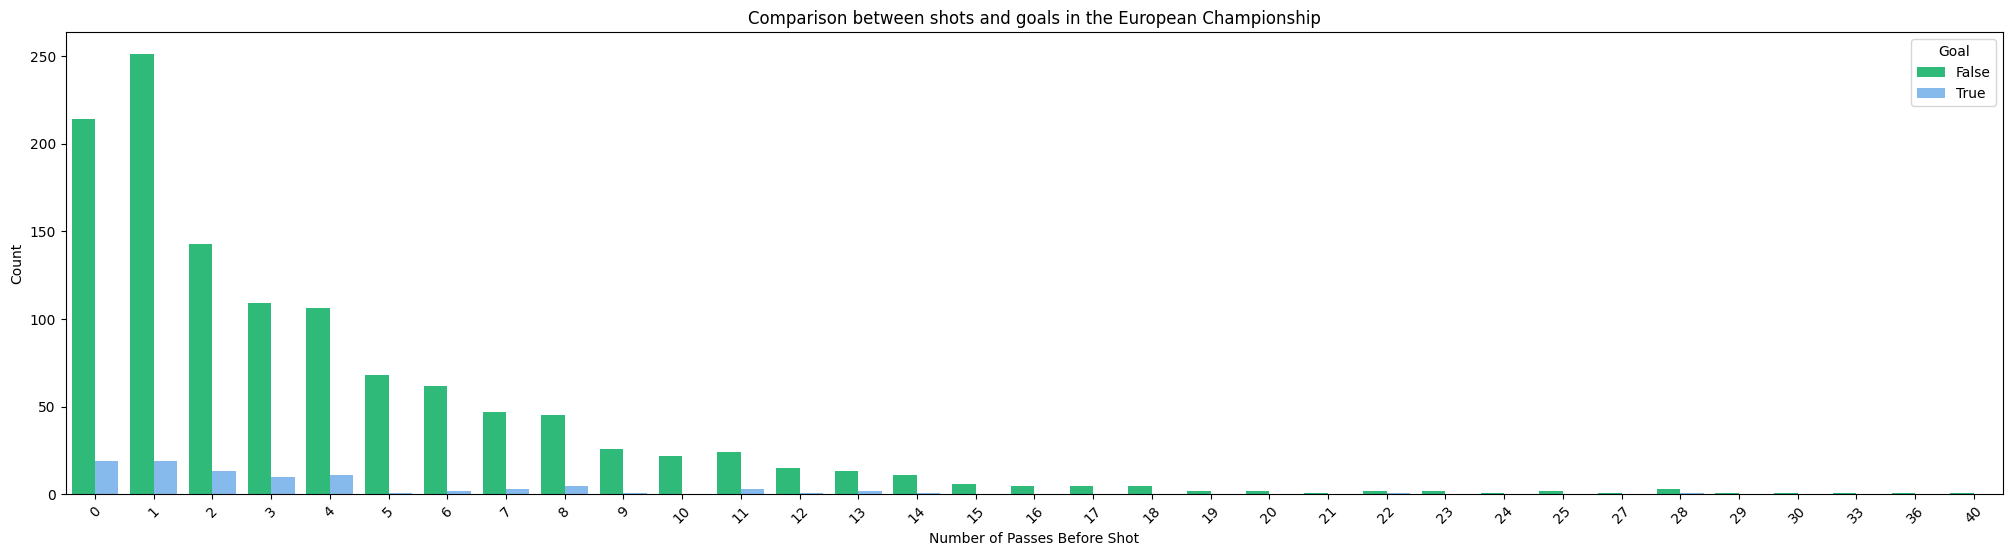

In [16]:
df1, df2, df3 = pass_chain_analysis('European_Championship', 'European Championship')
total_passes_counts = pd.concat([total_passes_counts, df1])
total_goals_passes_counts = pd.concat([total_goals_passes_counts, df2])
total_comparison = pd.concat([total_comparison, df3])

### World Cup pass chain analysis

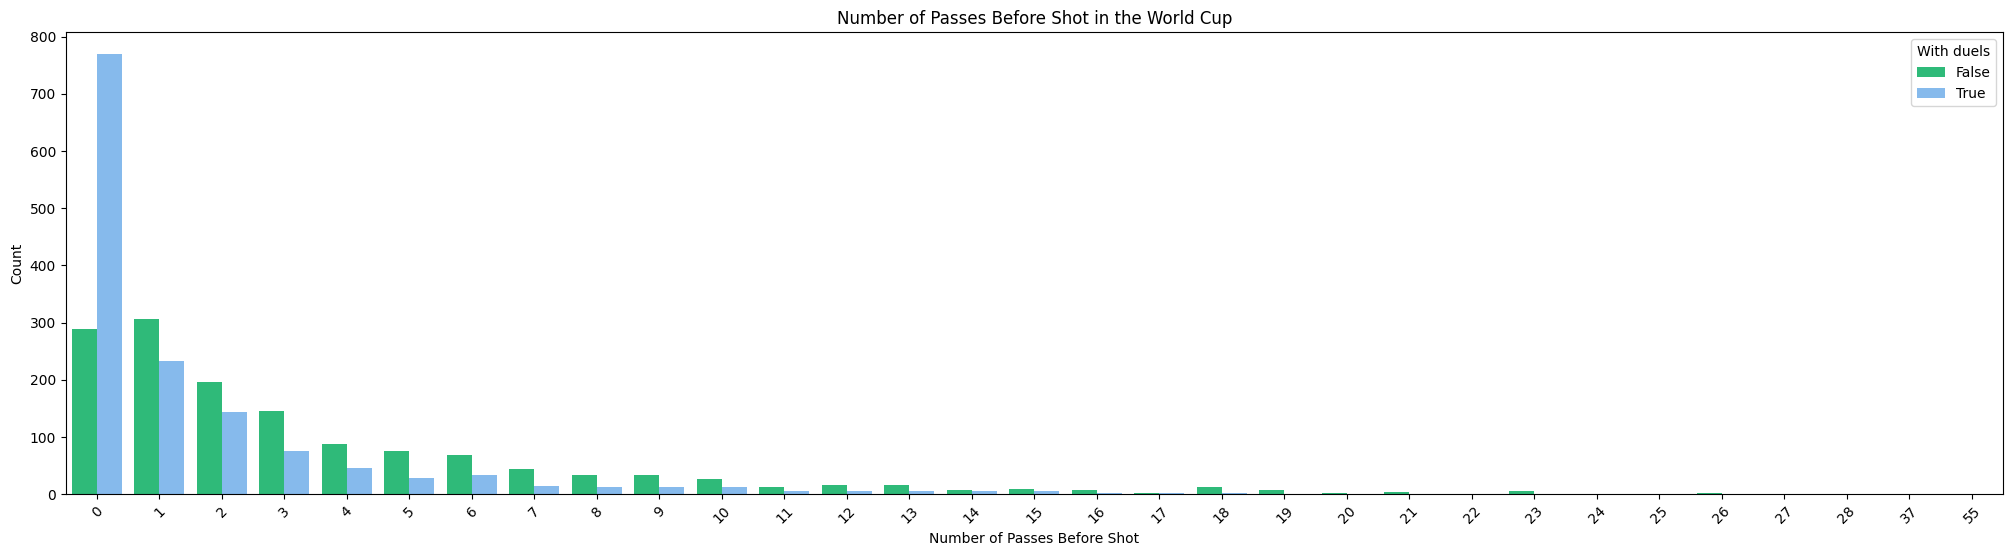

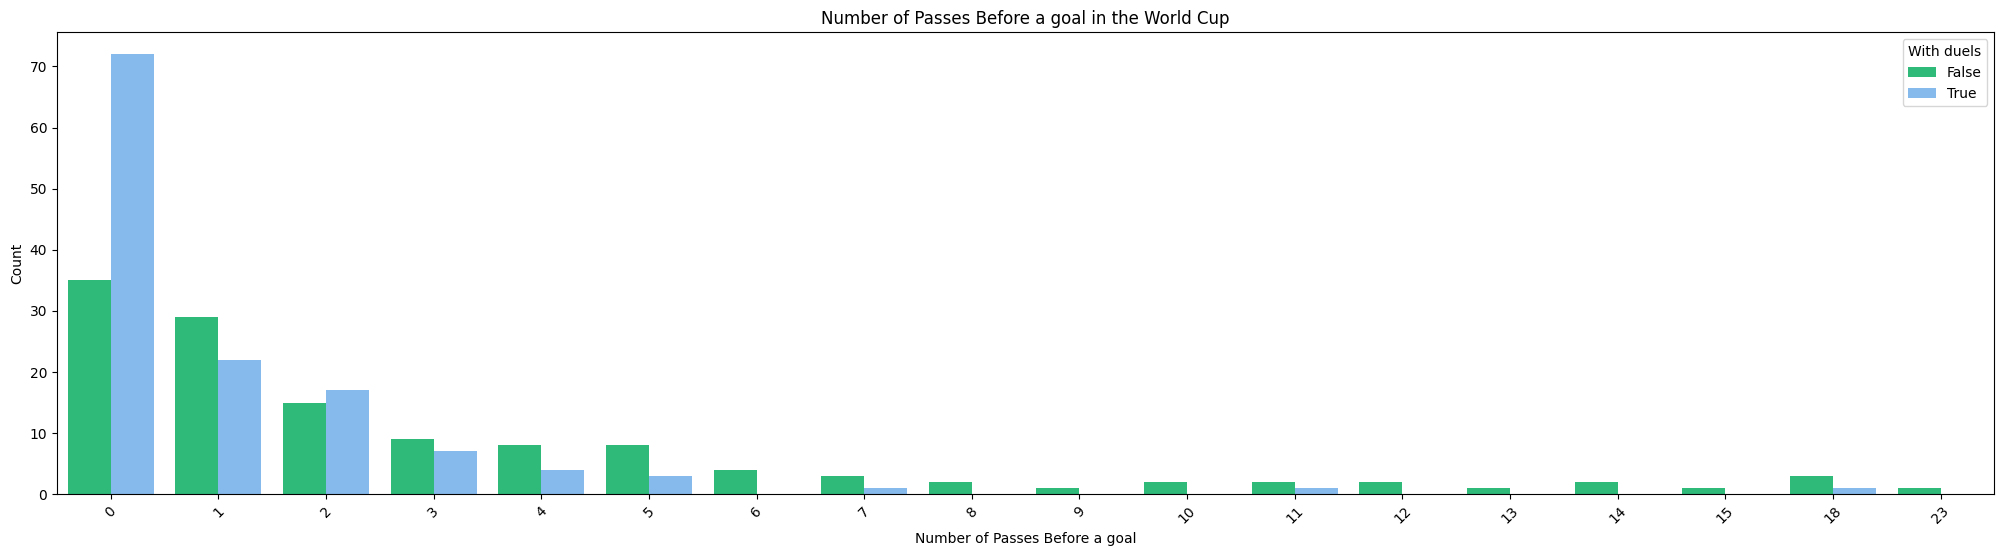

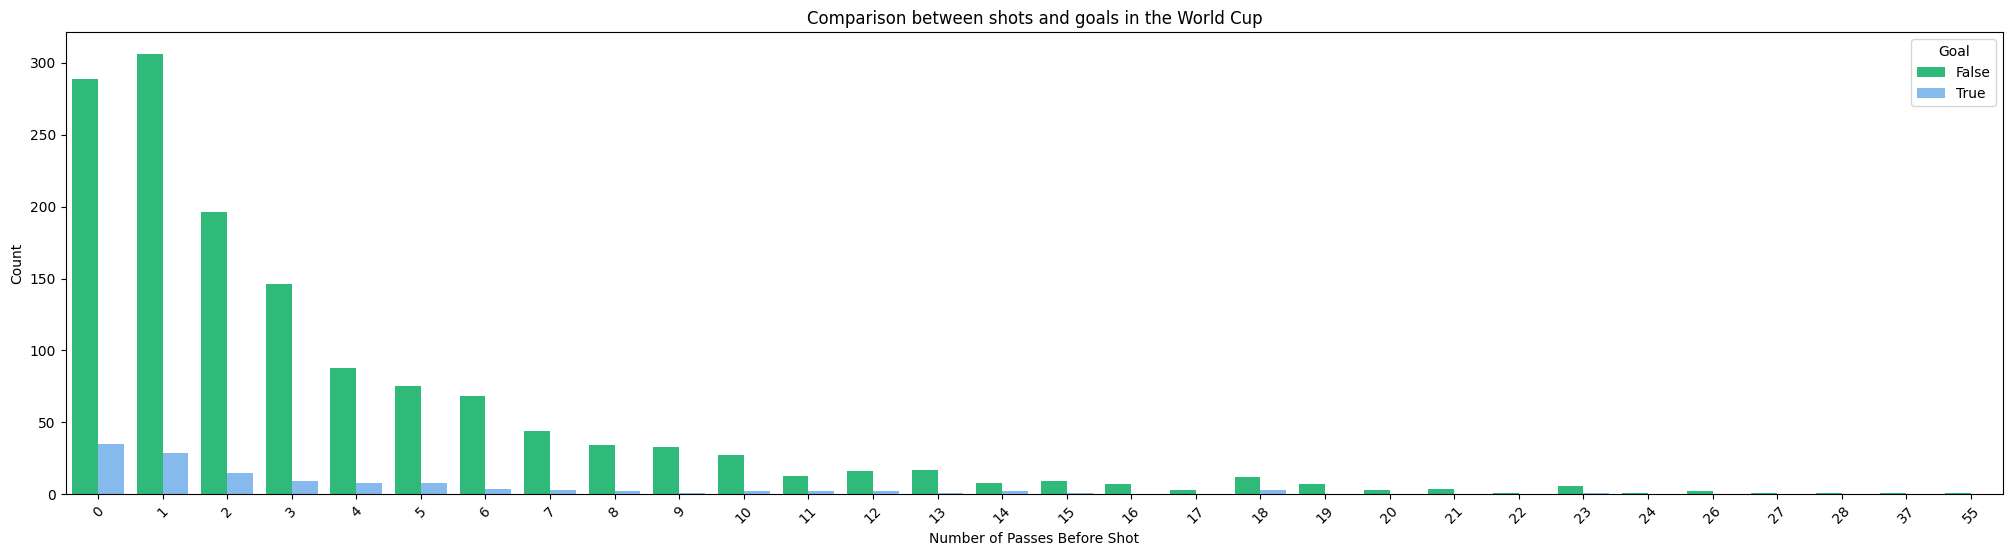

In [17]:
df1, df2, df3 = pass_chain_analysis('World_Cup', 'World Cup')
total_passes_counts = pd.concat([total_passes_counts, df1])
total_goals_passes_counts = pd.concat([total_goals_passes_counts, df2])
total_comparison = pd.concat([total_comparison, df3])

### Total analysis

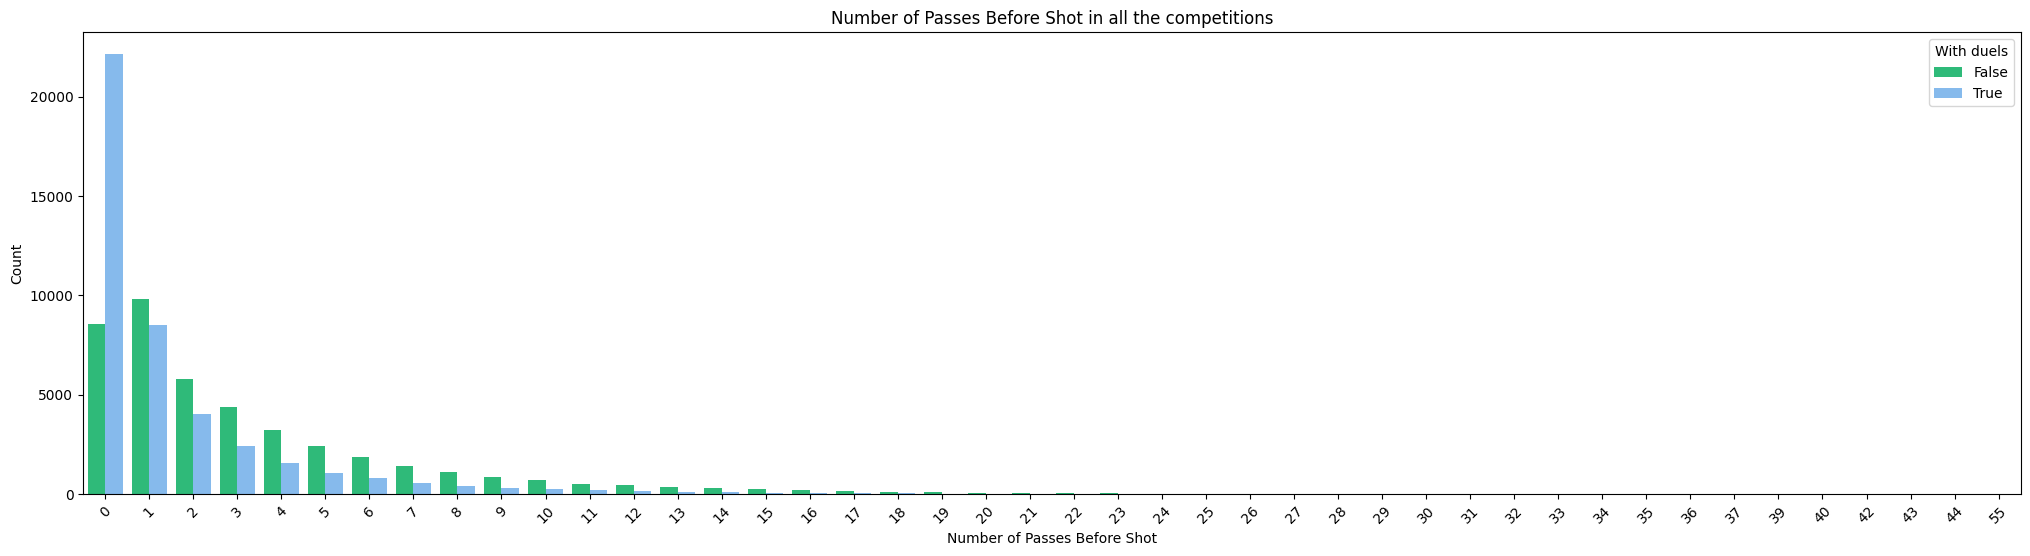

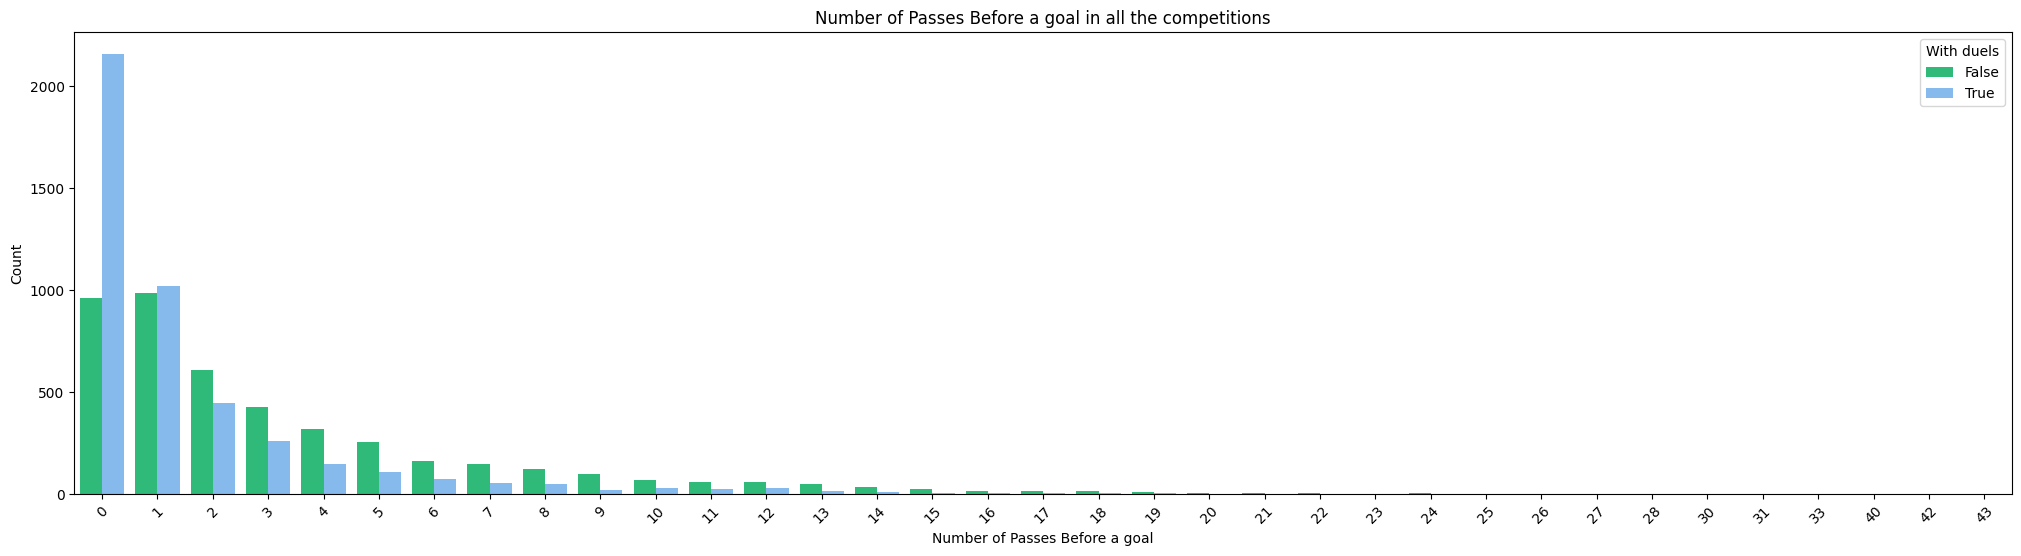

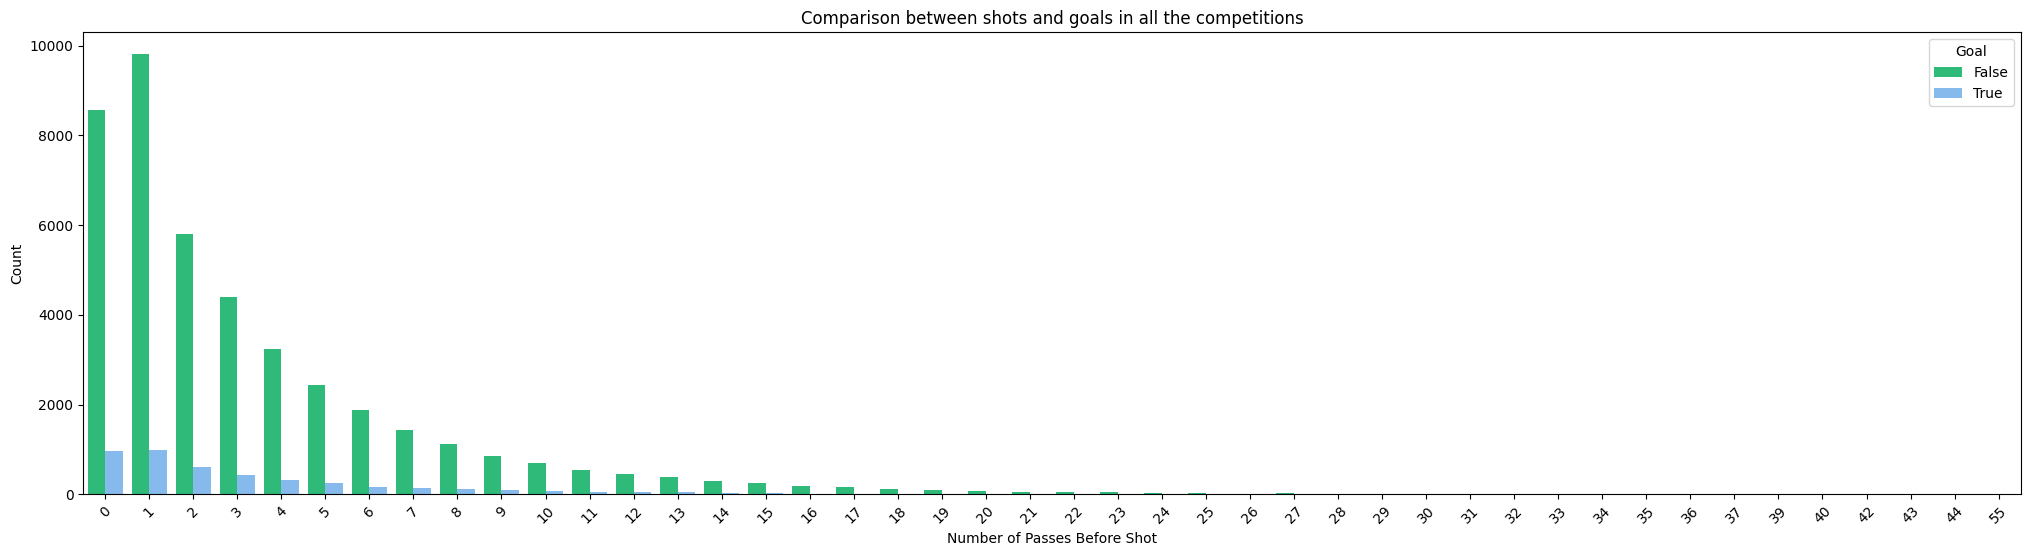

In [26]:
total_analysis(total_passes_counts, total_goals_passes_counts, total_comparison)